# Video Face Manipulation Detection Through Ensemble of CNNs
Image and Sound Processing Lab - Politecnico di Milano
- Nicolò Bonettini
- Edoardo Daniele Cannas
- Sara Mandelli
- Luca Bondi
- Paolo Bestagini

# Net fusion results analysis
The notebook analyzes the results of fusing different models results in different combinations

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.mkdir('/content/results')

In [3]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/DEEP_FAKE_DETECTION_2023/TEST_DFDC_part41/Xception_1000_imgs/results_1000_imgs.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/results')

with zipfile.ZipFile('/content/drive/MyDrive/DEEP_FAKE_DETECTION_2023/TEST_DFDC_part41/EfficientNetB4_1000_imgs/results_1000_imgs_EfficientNetB4.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/results')

with zipfile.ZipFile('/content/drive/MyDrive/DEEP_FAKE_DETECTION_2023/TEST_DFDC_part41/EfficientNetB4ST_1000_imgs/results_1000_imgs_EfficientNetB4ST.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/results')

with zipfile.ZipFile('/content/drive/MyDrive/DEEP_FAKE_DETECTION_2023/TEST_DFDC_part41/EfficientNetAutoAttB4_1000_imgs/results_1000_imgs_EfficientNetAutoAttB4.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/results')

with zipfile.ZipFile('/content/drive/MyDrive/DEEP_FAKE_DETECTION_2023/TEST_DFDC_part41/EfficientNetAutoAttB4ST_1000_imgs/results_1000_imgs_EfficientNetAutoAttB4ST.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/results')

## Libraries loading

In [4]:
%matplotlib inline
import ntpath
import os
from itertools import combinations
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as M
from scipy.special import expit
from sklearn.metrics import log_loss
from tqdm.notebook import tqdm

## Parameters

In [5]:
results_root = Path('/content/results/')
results_model_folder = list(results_root.glob('net-*'))
column_list = ['video', 'score', 'label']
do_distplot = False

## Helper functions

In [6]:
def compute_metrics(df_res:pd.DataFrame,train_tag:str) -> dict:
    numreal = sum(df_res['label']==False)
    numfake = sum(df_res['label']==True
)

    netname = train_tag.split('net-')[1].split('_')[0]
    traindb = train_tag.split('traindb-')[1].split('_')[0]

    loss = M.log_loss(df_res['label'],expit(df_res['score']))
    acc = M.accuracy_score(df_res['label'],df_res['score']>0)
    accbal = M.balanced_accuracy_score(df_res['label'],df_res['score']>0)
    rocauc = M.roc_auc_score(df_res['label'],df_res['score'])

    res_dict = {'traintag':train_tag,
                'net':netname,
                'traindb': traindb,
                'testdb':testdb,'testsplit':testsplit,
                'numreal':numreal,'numfake':numfake,
                'loss':loss,
                'acc':acc,'accbal':accbal,
                'rocauc':rocauc}
    return res_dict

In [7]:
def get_df(video_all_df, dataset):
    selected_df = video_all_df.loc[dataset].unstack(['model'])['score']
    models = selected_df.columns
    aux_df = video_all_df.loc[dataset].unstack(['model'])['video']
    selected_df['video'] = aux_df[aux_df.columns[0]]
    selected_df['label'] = video_all_df.loc[dataset].unstack(['model'])['label'].mean(axis=1)
    mapper = dict()
    for model in models:
        mapper[model] = model.split('net-')[1].split('_traindb')[0]
    selected_df = selected_df.rename(mapper, axis=1)
    return selected_df

## Load data

In [8]:
# Load data in multi-index dataframe
if os.path.exists('data_frame_df.pkl'):
    data_frame_df = pd.read_pickle('data_frame_df.pkl')
    model_list = []
    for model_folder in tqdm(results_model_folder):
        dataset_list = []
        train_model_tag = model_folder.name
        model_results = model_folder.glob('*.pkl')
        for model_path in model_results:
            dataset_tag = os.path.splitext(ntpath.split(model_path)[1])[0]
            dataset_list.append(dataset_tag)
        model_list.append(train_model_tag)
else:
    data_model_list = []
    model_list = []
    for model_folder in tqdm(results_model_folder):
        data_dataset_list = []
        dataset_list = []
        train_model_tag = model_folder.name
        model_results = model_folder.glob('*.pkl')
        for model_path in model_results:
            netname = train_model_tag.split('net-')[1].split('_')[0]
            traindb = train_model_tag.split('traindb-')[1].split('_')[0]
            testdb, testsplit = model_path.with_suffix('').name.rsplit('_',1)
            dataset_tag = os.path.splitext(ntpath.split(model_path)[1])[0]
            df_frames = pd.read_pickle(model_path)[column_list]
            # Add info on training and test datasets
            df_frames['netname'] = netname
            df_frames['train_db'] = traindb
            df_frames['test_db'] = testdb
            df_frames['test_split'] = testsplit
            data_dataset_list.append(df_frames)
            dataset_list.append(dataset_tag)
        data_model_list.append(pd.concat(data_dataset_list, keys=dataset_list, names=['dataset']))
        model_list.append(train_model_tag)
    data_frame_df = pd.concat(data_model_list, keys=model_list, names=['model']).swaplevel(0, 1)
    data_frame_df.to_pickle('data_frame_df.pkl')

  0%|          | 0/5 [00:00<?, ?it/s]

### Remove cross-test

In [9]:
idx_same_train_test = data_frame_df['train_db'] == data_frame_df['test_db']
data_frame_df = data_frame_df.loc[idx_same_train_test]

### Eliminate Xception experiments, consider only test sets

In [10]:
data_frame_df = data_frame_df[data_frame_df['test_split']=='test']
dataset_list = [x for x in dataset_list if "_val" not in x]
print('Datasets considered are {}'.format(dataset_list))
model_selection_list = ['EfficientNetB4', 'EfficientNetAutoAttB4', 'EfficientNetB4ST', 'EfficientNetAutoAttB4ST']
xception_df = data_frame_df[data_frame_df['netname'].isin(['Xception'])]
data_frame_df = data_frame_df[data_frame_df['netname'].isin(model_selection_list)]
model_list = data_frame_df.index.get_level_values(1).unique()
print('Models considered are {}'.format(data_frame_df['netname'].unique()))

Datasets considered are ['dfdc-35-5-10_test']
Models considered are ['EfficientNetB4' 'EfficientNetB4ST' 'EfficientNetAutoAttB4ST'
 'EfficientNetAutoAttB4']


In [11]:
selected_df = get_df(data_frame_df, dataset='dfdc-35-5-10_test')
selected_df.head()

model,EfficientNetB4,EfficientNetB4ST,EfficientNetAutoAttB4ST,EfficientNetAutoAttB4,video,label
facepath,,,,,,
dfdc_train_part_41/nwvtbjcvsd.mp4/fr000_subj0.jpg,-1.699852,-2.218237,-2.325481,-2.449275,nwvtbjcvsd.mp4,1.0
dfdc_train_part_41/nwvtbjcvsd.mp4/fr009_subj0.jpg,-1.220830,-2.074795,-1.371693,-1.666716,nwvtbjcvsd.mp4,1.0
dfdc_train_part_41/nwvtbjcvsd.mp4/fr019_subj0.jpg,-2.992827,-2.896441,-3.404441,-3.498112,nwvtbjcvsd.mp4,1.0
dfdc_train_part_41/nwvtbjcvsd.mp4/fr028_subj0.jpg,-3.406304,-2.803704,-3.061971,-2.747122,nwvtbjcvsd.mp4,1.0
dfdc_train_part_41/nwvtbjcvsd.mp4/fr038_subj0.jpg,-4.224640,-2.861709,-2.190233,-3.722433,nwvtbjcvsd.mp4,1.0


## Pair plot per-frame

In [ ]:
# FF++
net_list = list(data_frame_df['netname'].unique())
selected_df = get_df(data_frame_df, dataset='ff-c23-720-140-140_test')
selected_df[net_list] = selected_df[net_list].apply(expit)
selected_df = selected_df.rename(columns={'EfficientNetAutoAttB4': 'EfficientNetAttB4',
                                          'EfficientNetAutoAttB4ST': 'EfficientNetAttB4ST'})
selected_df = selected_df.sample(n=2000, random_state=0)
selected_df = selected_df.drop(columns=['video'])

selected_df['label'] = selected_df['label'].apply(lambda x: 'Fake' if x==1 else 'Real')
g = sns.pairplot(selected_df, hue='label', plot_kws=dict(alpha=0.03));
g._legend.remove()

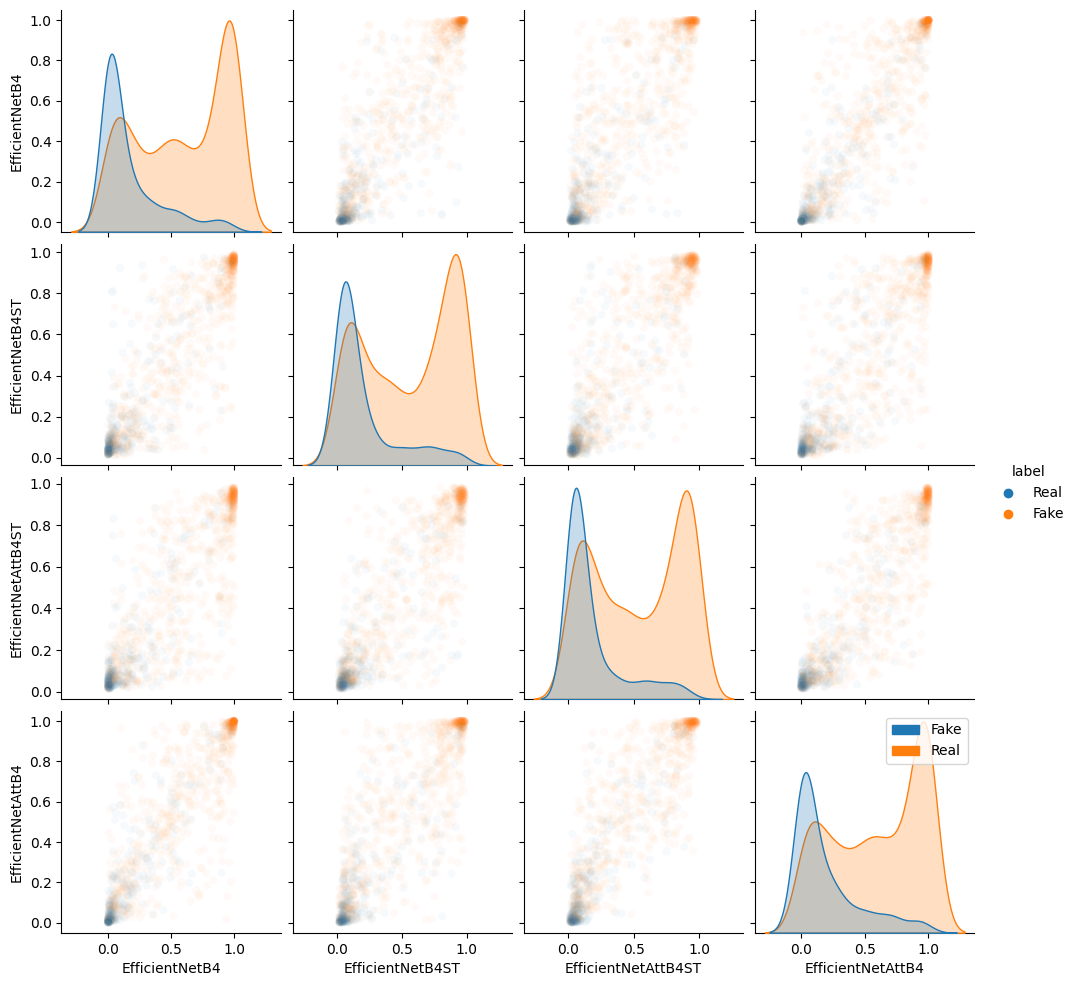

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # Importa o módulo para criar patches (retângulos coloridos)

net_list = list(data_frame_df['netname'].unique())
selected_df = get_df(data_frame_df, dataset='dfdc-35-5-10_test')
selected_df[net_list] = selected_df[net_list].apply(expit)
selected_df = selected_df.rename(columns={'EfficientNetAutoAttB4': 'EfficientNetAttB4',
                                          'EfficientNetAutoAttB4ST': 'EfficientNetAttB4ST'})
selected_df = selected_df.sample(n=1000, random_state=0)
selected_df = selected_df.drop(columns=['video'])

selected_df['label'] = selected_df['label'].apply(lambda x: 'Fake' if x == 1 else 'Real')
g = sns.pairplot(selected_df, hue='label', plot_kws=dict(alpha=0.03))

# Criar uma legenda personalizada
fake_patch = mpatches.Patch(color=sns.color_palette()[0], label='Fake')
real_patch = mpatches.Patch(color=sns.color_palette()[1], label='Real')
plt.legend(handles=[fake_patch, real_patch])

# Salvar a imagem do pairplot
plt.savefig('Pair_plot_per-frame_DFDC_with_legend.png')

# Mostrar o gráfico (opcional)
plt.show()


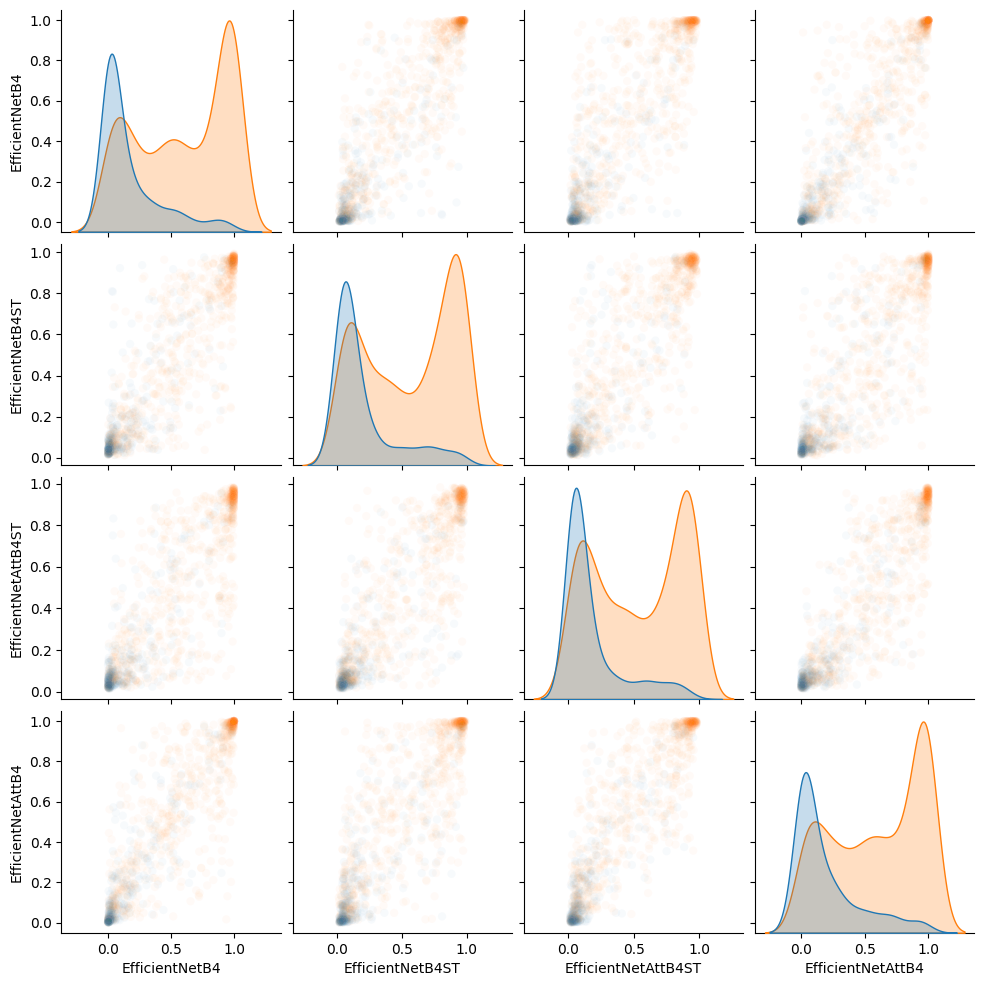

In [11]:
# DFDC
import seaborn as sns
import matplotlib.pyplot as plt


net_list = list(data_frame_df['netname'].unique())
selected_df = get_df(data_frame_df, dataset='dfdc-35-5-10_test')
selected_df[net_list] = selected_df[net_list].apply(expit)
selected_df = selected_df.rename(columns={'EfficientNetAutoAttB4': 'EfficientNetAttB4',
                                          'EfficientNetAutoAttB4ST': 'EfficientNetAttB4ST'})
selected_df = selected_df.sample(n=1000, random_state=0)
selected_df = selected_df.drop(columns=['video'])

selected_df['label'] = selected_df['label'].apply(lambda x: 'Fake' if x==1 else 'Real')
g = sns.pairplot(selected_df, hue='label', plot_kws=dict(alpha=0.03));
g._legend.remove()
# Salvar a imagem do pairplot
plt.savefig('Pair_plot_per-frame_DFDC.png')

# Mostrar o gráfico (opcional)
plt.show()

## Pair plot per-video


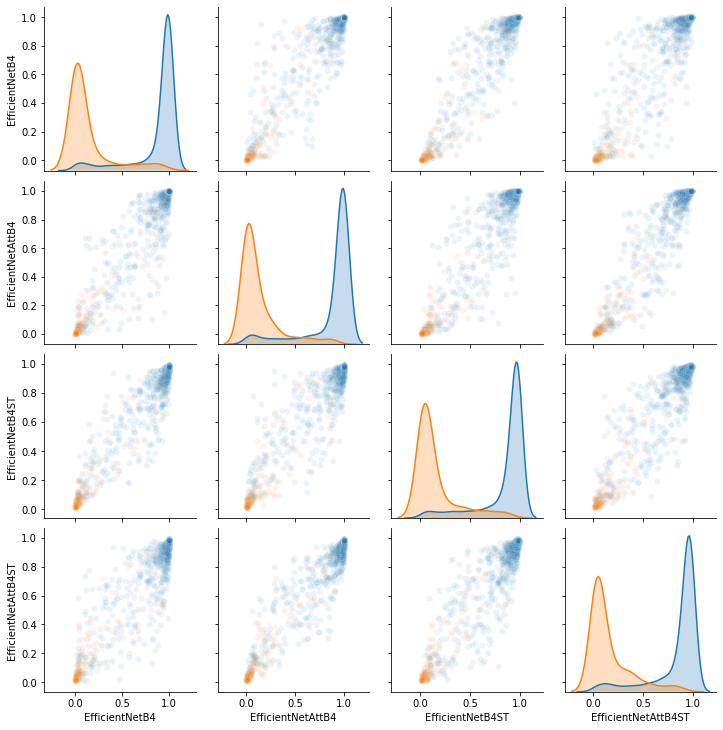

In [ ]:
# FF++
net_list = list(data_frame_df['netname'].unique())
selected_df = get_df(data_frame_df, dataset='ff-c23-720-140-140_test')
selected_df = selected_df.groupby('video')
selected_df_video = selected_df.mean().apply(expit)
selected_df_video = selected_df_video.rename(columns={'EfficientNetAutoAttB4': 'EfficientNetAttB4',
                                          'EfficientNetAutoAttB4ST': 'EfficientNetAttB4ST'})

selected_df_video['label'] = selected_df['label'].mean().apply(lambda x: 'Fake' if x==1 else 'Real')
g = sns.pairplot(selected_df_video, hue='label', plot_kws=dict(alpha=0.08))
g._legend.remove()

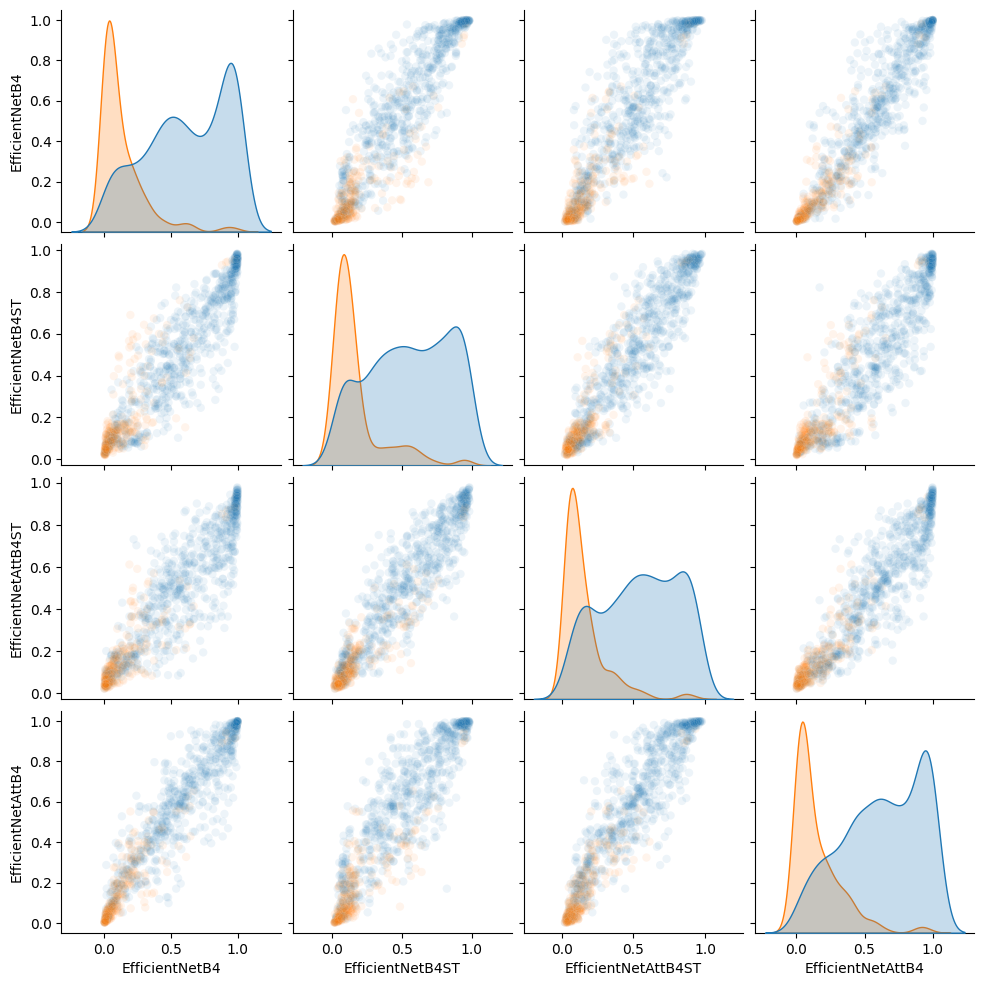

In [12]:
# DFDC
import seaborn as sns
import matplotlib.pyplot as plt

net_list = list(data_frame_df['netname'].unique())
selected_df = get_df(data_frame_df, dataset='dfdc-35-5-10_test')
selected_df = selected_df.groupby('video')
selected_df_video = selected_df.mean().apply(expit)
selected_df_video = selected_df_video.rename(columns={'EfficientNetAutoAttB4': 'EfficientNetAttB4',
                                          'EfficientNetAutoAttB4ST': 'EfficientNetAttB4ST'})
selected_df_video = selected_df_video.sample(n=1000, random_state=0)

selected_df_video['label'] = selected_df['label'].mean().apply(lambda x: 'Fake' if x==1 else 'Real')
g = sns.pairplot(selected_df_video, hue='label', plot_kws=dict(alpha=0.08))
g._legend.remove()

# Salvar a imagem do pairplot
plt.savefig('Pair_plot_per-video_DFDC.png')

# Mostrar o gráfico (opcional)
plt.show()

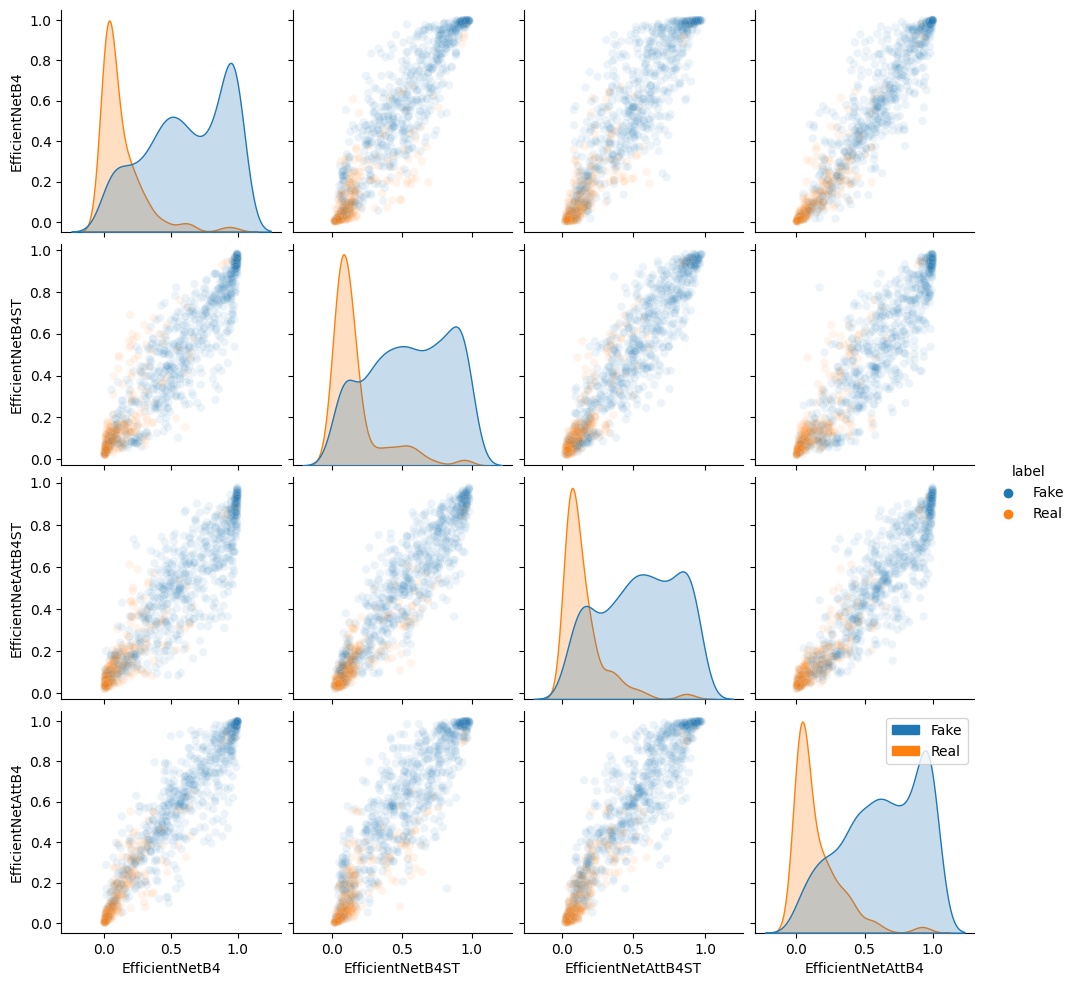

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

net_list = list(data_frame_df['netname'].unique())
selected_df = get_df(data_frame_df, dataset='dfdc-35-5-10_test')
selected_df = selected_df.groupby('video')
selected_df_video = selected_df.mean().apply(expit)
selected_df_video = selected_df_video.rename(columns={'EfficientNetAutoAttB4': 'EfficientNetAttB4',
                                          'EfficientNetAutoAttB4ST': 'EfficientNetAttB4ST'})
selected_df_video = selected_df_video.sample(n=1000, random_state=0)

selected_df_video['label'] = selected_df['label'].mean().apply(lambda x: 'Fake' if x==1 else 'Real')
g = sns.pairplot(selected_df_video, hue='label', plot_kws=dict(alpha=0.08))

# Criar uma legenda personalizada
fake_patch = mpatches.Patch(color=sns.color_palette()[0], label='Fake')
real_patch = mpatches.Patch(color=sns.color_palette()[1], label='Real')
plt.legend(handles=[fake_patch, real_patch])

# Salvar a imagem do pairplot
plt.savefig('Pair_plot_per-video_DFDC_with_legend.png')

# Mostrar o gráfico (opcional)
plt.show()


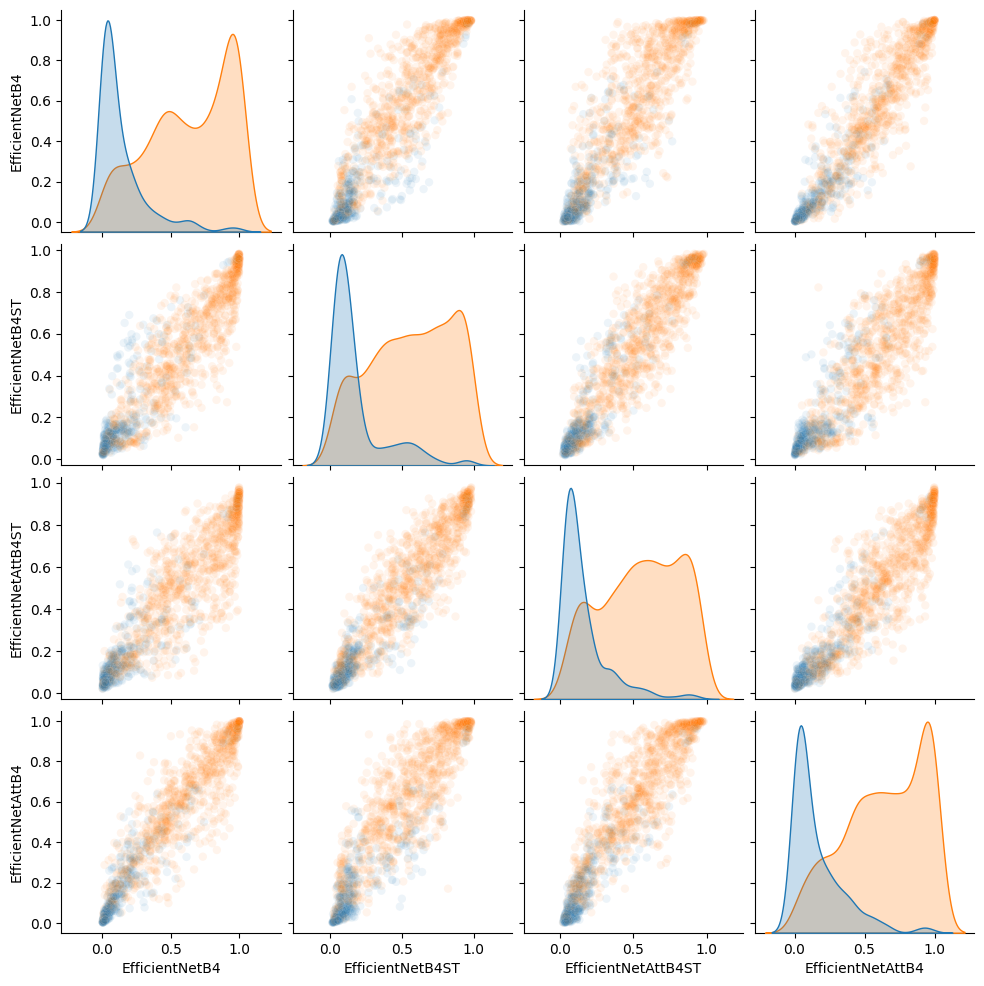

In [15]:
# TESTE DE BALANCEAMENTO DO NÚMERO DE VÍDEOS REAIS E FALSOS
import seaborn as sns
import matplotlib.pyplot as plt

net_list = list(data_frame_df['netname'].unique())
selected_df = get_df(data_frame_df, dataset='dfdc-35-5-10_test')
selected_df = selected_df.groupby('video')
selected_df_video = selected_df.mean().apply(expit)
selected_df_video = selected_df_video.rename(columns={'EfficientNetAutoAttB4': 'EfficientNetAttB4',
                                          'EfficientNetAutoAttB4ST': 'EfficientNetAttB4ST'})

selected_df_video['label'] = selected_df['label'].mean().apply(lambda x: 'Fake' if x == 1 else 'Real')
g = sns.pairplot(selected_df_video, hue='label', plot_kws=dict(alpha=0.08))
g._legend.remove()

# Salvar a imagem do pairplot
plt.savefig('Pair_plot_per-video_DFDC22.png')

# Mostrar o gráfico (opcional)
plt.show()



## Xception per-frame

In [ ]:
net_list = ['Xception']
comb_list = list(combinations(net_list, 1))
iterables = [dataset_list, ['loss', 'auc']]
index = pd.MultiIndex.from_product(iterables, names=['dataset', 'metric'])
results_x_df = pd.DataFrame(index=index, columns=comb_list)

In [ ]:
for dataset in dataset_list:
    print(dataset)
    for model_comb in tqdm(comb_list):
        df = get_df(xception_df, dataset)
        results_x_df[model_comb][dataset, 'loss'] = log_loss(df['label'], expit(np.mean(df[list(model_comb)],
                                                                                      axis=1)))
        results_x_df[model_comb][dataset, 'auc'] = M.roc_auc_score(df['label'], expit(np.mean(df[list(model_comb)],
                                                                                            axis=1)))

dfdc-35-5-10_test


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
results_x_df.T

dataset     dfdc-35-5-10_test          
metric                   loss       auc
(Xception,)          1.230327  0.608699

## Xception per-video

In [ ]:
net_list = ['Xception']
comb_list = list(combinations(net_list, 1))
iterables = [dataset_list, ['loss', 'auc']]
index = pd.MultiIndex.from_product(iterables, names=['dataset', 'metric'])
results_x_df = pd.DataFrame(index=index, columns=comb_list)

In [ ]:
for dataset in dataset_list:
    print(dataset)
    for model_comb in tqdm(comb_list):
        df = get_df(xception_df, dataset)
        df = df.groupby('video')
        df = df.mean()
        results_x_df[model_comb][dataset, 'loss'] = log_loss(df['label'], expit(np.mean(df[list(model_comb)],
                                                                                      axis=1)))
        results_x_df[model_comb][dataset, 'auc'] = M.roc_auc_score(df['label'], expit(np.mean(df[list(model_comb)],
                                                                                            axis=1)))

dfdc-35-5-10_test


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
results_x_df.T

dataset     dfdc-35-5-10_test          
metric                   loss       auc
(Xception,)          1.093006  0.635666

## Combinations per-frame

In [ ]:
net_list = list(data_frame_df['netname'].unique())
comb_list_1 = list(combinations(net_list, 1))
comb_list_2 = list(combinations(net_list, 2))
comb_list_3 = list(combinations(net_list, 3))
comb_list_4 = list(combinations(net_list, 4))
comb_list = comb_list_1 + comb_list_2 + comb_list_3 + comb_list_4
iterables = [dataset_list, ['loss', 'auc']]
index = pd.MultiIndex.from_product(iterables, names=['dataset', 'metric'])
results_df = pd.DataFrame(index=index, columns=comb_list)

In [ ]:
for dataset in dataset_list:
    print(dataset)
    for model_comb in tqdm(comb_list):
        df = get_df(data_frame_df, dataset)
        results_df[model_comb][dataset, 'loss'] = log_loss(df['label'], expit(np.mean(df[list(model_comb)],
                                                                                      axis=1)))
        results_df[model_comb][dataset, 'auc'] = M.roc_auc_score(df['label'], expit(np.mean(df[list(model_comb)],
                                                                                            axis=1)))

dfdc-35-5-10_test


  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
results_df.T

dataset                                            dfdc-35-5-10_test          
metric                                                          loss       auc
(EfficientNetB4,)                                           0.727085  0.839851
(EfficientNetAutoAttB4ST,)                                  0.768982  0.813688
(EfficientNetB4ST,)                                         0.783282  0.799328
(EfficientNetAutoAttB4,)                                    0.686414  0.836168
(EfficientNetB4, EfficientNetAutoAttB4ST)                   0.709863  0.841105
(EfficientNetB4, EfficientNetB4ST)                          0.729823  0.831184
(EfficientNetB4, EfficientNetAutoAttB4)                     0.684114  0.845705
(EfficientNetAutoAttB4ST, EfficientNetB4ST)                 0.747715  0.817774
(EfficientNetAutoAttB4ST, EfficientNetAutoAttB4)            0.699476  0.835929
(EfficientNetB4ST, EfficientNetAutoAttB4)                   0.701766  0.831424
(EfficientNetB4, EfficientNetAutoAttB4ST, Effic...          0.718535   0.83461
(EfficientNetB4, EfficientNetAutoAttB4ST, Effic...           0.68795  0.844449
(EfficientNetB4, EfficientNetB4ST, EfficientNet...          0.696209  0.839539
(EfficientNetAutoAttB4ST, EfficientNetB4ST, Eff...          0.705881  0.832986
(EfficientNetB4, EfficientNetAutoAttB4ST, Effic...          0.697132  0.839864

## Combinations per-video

In [ ]:
net_list = list(data_frame_df['netname'].unique())
comb_list_1 = list(combinations(net_list, 1))
comb_list_2 = list(combinations(net_list, 2))
comb_list_3 = list(combinations(net_list, 3))
comb_list_4 = list(combinations(net_list, 4))
comb_list = comb_list_1 + comb_list_2 + comb_list_3 + comb_list_4
iterables = [dataset_list, ['loss', 'auc']]
index = pd.MultiIndex.from_product(iterables, names=['dataset', 'metric'])
results_df = pd.DataFrame(index=index, columns=comb_list)

In [ ]:
for dataset in dataset_list:
    print(dataset)
    for model_comb in tqdm(comb_list):
        df = get_df(data_frame_df, dataset)
        df = df.groupby('video')
        df = df.mean()
        results_df[model_comb][dataset, 'loss'] = log_loss(df['label'], expit(np.mean(df[list(model_comb)],
                                                                                      axis=1)))
        results_df[model_comb][dataset, 'auc'] = M.roc_auc_score(df['label'], expit(np.mean(df[list(model_comb)],
                                                                                            axis=1)))

dfdc-35-5-10_test


  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
results_df.T

dataset                                            dfdc-35-5-10_test          
metric                                                          loss       auc
(EfficientNetB4,)                                           0.558293  0.905953
(EfficientNetAutoAttB4ST,)                                  0.621989  0.890906
(EfficientNetB4ST,)                                         0.631793  0.864507
(EfficientNetAutoAttB4,)                                    0.510836  0.911631
(EfficientNetB4, EfficientNetAutoAttB4ST)                   0.569385  0.906507
(EfficientNetB4, EfficientNetB4ST)                          0.579754  0.896168
(EfficientNetB4, EfficientNetAutoAttB4)                     0.525134  0.912752
(EfficientNetAutoAttB4ST, EfficientNetB4ST)                 0.618291  0.883567
(EfficientNetAutoAttB4ST, EfficientNetAutoAttB4)            0.550414   0.90805
(EfficientNetB4ST, EfficientNetAutoAttB4)                   0.555436  0.898943
(EfficientNetB4, EfficientNetAutoAttB4ST, Effic...          0.583771  0.898401
(EfficientNetB4, EfficientNetAutoAttB4ST, Effic...          0.543413  0.911064
(EfficientNetB4, EfficientNetB4ST, EfficientNet...          0.549027   0.90521
(EfficientNetAutoAttB4ST, EfficientNetB4ST, Eff...           0.56986  0.899577
(EfficientNetB4, EfficientNetAutoAttB4ST, Effic...          0.559082  0.904743